This Notebooks contain the lastest version of the full model of optimisation

In [2]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
# Trouve le dossier racine du projet (celui qui contient 'src')
project_root = Path().resolve().parents[0]
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.cm as cm
from matplotlib.lines import Line2D

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix


from utils_traffic import *
import logging
logging.getLogger("aequilibrae").setLevel(logging.ERROR)

from pypalettes import load_palette

In [17]:
###### preprocessing functions
def set_capacity_cars(edges_df, capacity_per_lane=100, lanes_col='lanes'):
    edges_df['capacity_cars'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def set_capacity_bikes(edges_df, capacity_per_lane=200, lanes_col='lanes'):
    edges_df['capacity_bikes'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def time_estimation_cars(edges_df):
    travel_time = []
    for _, edge in edges_df.iterrows():
        travel_time.append((edge['length']/1000)/(edge['speed']*0.5))
    edges_df['travel_time_cars'] = travel_time
    return edges_df

def free_flow_time (edges_df, mode):
    name_col = 'free_flow_time_' + mode
    edges_df[name_col] = edges_df['length']/ (edges_df['speed_'+ mode])
    return edges_df

def simple_bi(edges_df, coef = 1):
    length_bi = []
    for _, edge in edges_df.iterrows():
        if edge['type_bike'] == 'bike_lane':
            length_bi.append(edge['length']*0.9*coef)
        elif edge['type_bike'] == 'bike_path':
            length_bi.append(edge['length']*0.5*coef)
        else:
            length_bi.append(edge['length']*2*coef)
    edges_df['length_bi'] = length_bi
    return edges_df

def estimate_traffic (edges_df):
    traffic = []
    for _, edge in edges_df.iterrows():
        if edge['type_car']=='primary':
            traffic.append(500)
        elif edge['type_car']=='secondary':
            traffic.append(250)
        else :
            traffic.append(100)
    edges_df['traffic'] = traffic
    return edges_df

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 3000:
        return 1.7
    elif traffic < 100:
        return 0.9
    else :
        return 1.3
    

def simple_bi_2(edges_df, traffic_col='traffic'):
    length_bi = []
    for _, edge in edges_df.iterrows():
        perceived_l = 0
        perceived_l += pl_type_bike(edge['type_bike'])
        perceived_l += pl_slope(edge['slope'])
        perceived_l += pl_green(edge['green_blue_coverage'])
        perceived_l += pl_traffic(edge[traffic_col])
        length_bi.append(perceived_l/4)
    edges_df['length_bi'] = length_bi*edges_df['length']
    edges_df['length_bi'] = edges_df['length_bi'].astype(np.float64)
    return edges_df

def simple_bi_3 (edge_df, traffic_car_col='flow_car', coef=1):
    liste_length_bi = []
    for _, edge in edge_df.iterrows():
        if edge['type_bike'] == 'bike_path':
            perceived_l = 0.5
        else :
            if edge[traffic_car_col]<800:
                perceived_l = 0.8
            elif edge[traffic_car_col]>=800 and edge[traffic_car_col]<1000:
                perceived_l = 1
            elif edge[traffic_car_col]>=1000 and edge[traffic_car_col]<3000:
                perceived_l = 1.2
            else:
                perceived_l = 1.7
        liste_length_bi.append(perceived_l*coef)
    edge_df['length_bi'] = edge_df['length']*liste_length_bi
    edge_df['length_bi'] = edge_df['length_bi'].astype(np.float64)
    return edge_df

def reset_flows(edges_df, flow_key='flow'):
    edges_df[flow_key] = 0
    return edges_df

def change_type_bike(edges_df, a_node, b_node, new_type):
    edges_df = edges_df.copy()
    idx = edges_df[(edges_df['a_node']==a_node) & (edges_df['b_node']==b_node)].index
    edges_df.loc[idx, 'type_bike'] = new_type
    return edges_df


#### plotting functions
def _create_offset_polygon(coords, width):
    """Create polygon offset to right of line."""
    if len(coords) < 2:
        return None

    right_pts, left_pts = [], []
    for i, (cx, cy) in enumerate(coords):
        if i == 0:
            dx, dy = coords[1][0] - coords[0][0], coords[1][1] - coords[0][1]
        elif i == len(coords) - 1:
            dx, dy = coords[-1][0] - coords[-2][0], coords[-1][1] - coords[-2][1]
        else:
            dx = (coords[i + 1][0] - coords[i - 1][0]) / 2
            dy = (coords[i + 1][1] - coords[i - 1][1]) / 2

        length = np.sqrt(dx ** 2 + dy ** 2)
        if length > 0:
            dx, dy = dx / length, dy / length

        perp_x, perp_y = dy, -dx
        right_pts.append((cx + perp_x * width, cy + perp_y * width))
        left_pts.append((cx, cy))

    try:
        polygon = Polygon(right_pts + left_pts[::-1])
        return polygon if polygon.is_valid else polygon.buffer(0)
    except:
        return None

def plot_network(edges_df, nodes_df, ax=None, figsize=(10,10), node_x_col='x', node_y_col='y', 
                 width_col=None, base_width=0.1, width_scale=2.1, node_id_col='node', color_col_num=None, color_col_str=None, dict_colors_str=None,
                 vmin=None, vmax=None, a_node_col='a_node', b_node_col='b_node', show_nodes=True,
                 node_size=100, cmap='viridis', colorbar_label=None, title=None, node_label=False, legend=False, edges_label_col=None, cbar_on=True):
    
    edges_df = edges_df.reset_index(drop=True)

    if dict_colors_str is not None:
        dict_colors = dict_colors_str
    else:
        dict_colors = {'bike_path': '#4E9F50FF', 'bike_lane': '#EF8A0CFF', 'none':'black'}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x_range = nodes_df[node_x_col].max() - nodes_df[node_x_col].min()
    y_range = nodes_df[node_y_col].max() - nodes_df[node_y_col].min()
    scale = min(x_range, y_range) / 100

    scaled_base = scale * base_width
    scaled_scale = scale * width_scale * 0.0001

    node_coords = {r[node_id_col]: (r[node_x_col], r[node_y_col])
                   for _, r in nodes_df.iterrows()}
    
    if width_col is not None:
        width_vals = edges_df[width_col].fillna(0).values if width_col in edges_df.columns else np.ones(len(edges_df))
        if color_col_num is None:
            color_col_num = width_col
    
    if color_col_num in edges_df.columns:
        color_vals = edges_df[color_col_num].fillna(0).values

        # Use provided vmin/vmax or compute from data
        if vmin is None:
            vmin = np.nanmin(color_vals)
        if vmax is None:
            vmax = np.nanmax(color_vals)
        if vmin == vmax:
            vmax = vmin + 1

        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        use_cmap = True
    else:
        use_cmap = False
    
    if color_col_str in edges_df.columns:
        color_vals = []
        for edge in edges_df.itertuples():
            color_vals.append(dict_colors.get(getattr(edge, color_col_str), 'black'))
        use_cmap = False
    
    if color_col_num is None and color_col_str is None:
        color_vals = ['black'] * len(edges_df)
        use_cmap = False
    # Use enumerate to get integer index for numpy array access
    for idx, edge in edges_df.iterrows():
        a_coords = node_coords.get(edge[a_node_col])
        b_coords = node_coords.get(edge[b_node_col])
        if a_coords is None or b_coords is None:
            continue

        # Use idx (which is now 0..N-1 due to reset_index) to access arrays
        if width_col is not None:
            width = scaled_base + width_vals[idx] * scaled_scale
        else:
            width = scaled_base
        polygon = _create_offset_polygon([a_coords, b_coords], width)

        if polygon:
            color = sm.to_rgba(color_vals[idx]) if use_cmap else color_vals[idx]
            x, y = polygon.exterior.xy
            ax.fill(x, y, color=color, alpha=1, edgecolor='black', linewidth=0.1)

    if show_nodes:
        ax.scatter(nodes_df[node_x_col], nodes_df[node_y_col], s=node_size, c='white', zorder=5, edgecolors='black')
        if node_label :
            for _, row in nodes_df.iterrows():
                ax.text(row[node_x_col], row[node_y_col], str(int(row[node_id_col])), fontsize=8,
                        ha='center', va='center', zorder=6)

    if legend and color_col_str is not None:
        legend_elements = []
        for key, color in dict_colors.items():
            legend_elements.append(Line2D([0], [0], color=color, lw=4, label=key))
        ax.legend(handles=legend_elements, loc='lower right')
        
    if use_cmap:
        # Determine colorbar label
        if colorbar_label is None:
            colorbar_label = color_col_num.replace('_', ' ').title()
        if cbar_on:
            cbar = plt.colorbar(sm, ax=ax, label=colorbar_label, shrink=0.8)

    if edges_label_col is not None and edges_label_col in edges_df.columns:
        for _, edge in edges_df.iterrows():
            a_coords = node_coords.get(edge[a_node_col])
            b_coords = node_coords.get(edge[b_node_col])
            if a_coords is None or b_coords is None:
                continue
            mid_x = (a_coords[0] + b_coords[0]) / 2
            mid_y = (a_coords[1] + b_coords[1]) / 2
            if a_coords[0] == b_coords[0]:  # horizontal line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white', rotation='vertical')
            else:  # vertical line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white')
            
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title or f'Network (width by {width_col})')
    plt.tight_layout()
    
    if ax is None:
        return fig, ax

def plot_vc_histogram(results_df, capacity_col='capacity', bins=5):
    """Plot V/C ratio histogram."""
    ratios = results_df['flow'] / results_df[capacity_col].replace(0, np.inf)
    ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()

    if len(ratios) == 0:
        print("No valid V/C ratios to plot")
        return None, None

    counts, edges = np.histogram(ratios, bins=bins)
    cmap = mcolors.LinearSegmentedColormap.from_list('', ['#2ecc71', '#f1c40f', '#e74c3c'])
    colors = [cmap(i / max(1, bins - 1)) for i in range(bins)]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(edges[:-1], counts, width=edges[1] - edges[0], color=colors, edgecolor='black', alpha=0.8, align='edge')

    for pos, cnt in zip(edges[:-1], counts):
        if cnt > 0:
            ax.text(pos + (edges[1] - edges[0]) / 2, cnt, str(int(cnt)), ha='center', va='bottom', fontweight='bold')

    ax.set_xlabel('Volume/Capacity Ratio')
    ax.set_ylabel('Number of Links')
    ax.set_title('Link Congestion Distribution')
    ax.grid(axis='y', alpha=0.6, linestyle='--')
    plt.tight_layout()

    return fig, ax

def plot_od_matrix(od_matrix, edges_df, nodes_df, ax=None, figsize=(10,10), cmap='viridis', title='OD Matrix', label=True, color='red', vmax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    plot_network(edges_df, nodes_df, ax=ax, show_nodes=True, node_label=True, node_size=300, title=title)
    od_matrix_plot = od_matrix.copy()[od_matrix['demand']>0]
    if vmax is None:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / od_matrix_plot['demand'].max() * 5
    else:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / vmax * 5
    

    for i, row in od_matrix_plot.iterrows():
        x0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'x'].values[0]
        y0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'y'].values[0]
        x1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'x'].values[0]
        y1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'y'].values[0]

        ax.annotate(
        "",
        xy=(x1, y1),      # destination
        xytext=(x0, y0),  # origine
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            lw=row['linewidth']
        ),
        zorder=3
        )
        if label :
            xm = (x0 + x1-100) / 2
            ym = (y0 + y1+100) / 2
            dx = x1 - x0
            dy = y1 - y0

            # Vecteur perpendiculaire unitaire
            nx = -dy
            ny = dx
            norm = np.sqrt(nx**2 + ny**2)
            nx /= norm
            ny /= norm

            # Distance du décalage (à ajuster si besoin)
            offset = 0.015 * np.hypot(dx, dy)

            # Position finale du texte
            xt = xm + nx * offset
            yt = ym + ny * offset

            # Texte
            ax.text(
                xt, yt,
                str(int(row['demand'])),
                color='black',
                fontsize=9,
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                zorder=4
            )

    
    if ax is None:
        return fig, ax
    
##### eaquilibrae pre processing

def convert_to_eaquilibrae_df(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    return edges_df

def convert_to_eaquilibrae_df_v2(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    edges_df_2 = edges_df.copy()
    edges_df_2.rename(columns={'a_node': 'b_node', 'b_node': 'a_node'}, inplace=True)
    edges_df = pd.concat([edges_df, edges_df_2], ignore_index=True)
    return edges_df, len(edges_df_2)

def convert_to_eaquilibrae_od_matrix(od_matrix):
    od_long = od_matrix.stack().reset_index()
    od_long.columns = ["origin", "destination", "demand"]
    return od_long

def convert_from_eaquilibrae_df_to_graph(results_stochastic):
    network_with_flows = results_stochastic['network']
    G_2 = nx.from_pandas_edgelist(
    network_with_flows,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2

def convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df):
    network_with_flows = results_stochastic['network']
    print(network_with_flows)
    base_df = network_with_flows[:len_df].copy()
    print(base_df)
    reversed_df = network_with_flows[len_df:].copy()
    print(reversed_df)
    base_df['flow'] = base_df['flow'] + reversed_df['flow'].values
    G_2 = nx.from_pandas_edgelist(
    base_df,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2



#####models

def _build_demand_matrix(od_gdf, name='matrix'):
    """Convert OD GeoDataFrame to AequilibraeMatrix."""
    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    od_matrix = np.zeros((zones, zones))

    for _, row in od_gdf.iterrows():
        od_matrix[int(row['origin']) - 1, int(row['destination']) - 1] = row['demand']

    demand = AequilibraeMatrix()
    demand.create_empty(zones=zones, matrix_names=[name], memory_only=True)
    demand.matrix[name][:, :] = od_matrix
    demand.index[:] = np.arange(1, zones + 1).astype(int)
    demand.computational_view([name])

    return demand

def _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field='capacity'):
    """Build graph for stochastic assignment."""
    network_df = network_df.copy()
    network_df['direction'] = 1
    network_df.index = list(range(len(network_df)))
    network_df["link_id"] = network_df.reset_index().index + 1
    network_df = network_df.astype({"a_node": "int64", "b_node": "int64", "direction": "int64", "link_id": "int64"})

    g = Graph()
    g.cost = network_df[cost_field].values
    g.capacity = network_df[capacity_field].values
    g.free_flow = network_df[time_field].values

    g.network = network_df
    g.network_ok = True
    g.status = 'OK'
    g.prepare_graph(np.arange(1, zones + 1).astype(int))
    g.set_graph(cost_field)
    g.cost = np.array(g.cost, copy=True)
    g.set_blocked_centroid_flows(False)
    g.network["id"] = g.network.link_id

    return g

def _empty_result(results_df, n):
    """Return empty result dict for failed assignments."""
    results_df['flow'] = np.zeros(n)
    results_df['time'] = np.zeros(n)
    return {
        'network': results_df,
        'total_travel_time': np.inf,
        'computation_time': 0,
        'rgap': np.inf,
        'flow': np.zeros(n),
        'time': np.zeros(n),
        'convergence': None
    }

def ta_due(edges_gdf, od_gdf, algorithm='bfw', max_iter=500, tolerance=1e-4,
           time_field='free_flow_time', cost_field='free_flow_time',capacity_field='capacity_cars'):
    """
    Deterministic User Equilibrium (DUE) traffic assignment.
    """
    network_df = edges_gdf.copy()
    if 'geometry' in network_df.columns:
        network_df = pd.DataFrame(network_df.drop(columns=['geometry']))

    network_df['alpha'] = network_df['alpha'].fillna(0.15)
    network_df['beta'] = network_df['beta'].fillna(4.0)
    network_df[capacity_field] = network_df[capacity_field].fillna(99999)
    network_df[time_field] = network_df[time_field].fillna(100.00)

    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    demand = _build_demand_matrix(od_gdf)

    network_df = network_df.sort_values(by=['a_node', 'b_node']).reset_index(drop=True)
    network_df['direction'] = 1
    network_df.index = list(range(len(network_df)))
    network_df["link_id"] = network_df.reset_index().index + 1
    network_df = network_df.astype({"a_node": "int64", "b_node": "int64", "direction": "int64", "link_id": "int64"})

    g = Graph()
    g.cost = network_df[cost_field].values
    g.capacity = network_df[capacity_field].values
    g.free_flow = network_df[time_field].values
    g.network = network_df
    g.network_ok = True
    g.status = 'OK'
    g.prepare_graph(np.arange(1, zones + 1).astype(int))
    g.set_graph(cost_field)
    g.cost = np.array(g.cost, copy=True)
    g.set_blocked_centroid_flows(False)
    g.network["id"] = g.network.link_id

    traffic_class = TrafficClass('car', g, demand)
    assignment = TrafficAssignment()
    assignment.set_classes([traffic_class])
    assignment.set_vdf('BPR')
    assignment.set_vdf_parameters({"alpha": "alpha", "beta": "beta"})
    assignment.set_capacity_field(capacity_field)
    assignment.set_time_field(cost_field)
    assignment.set_algorithm(algorithm)
    assignment.max_iter = max_iter
    assignment.rgap_target = tolerance

    results_df = network_df.copy()
    start_time = time.time()

    try:
        assignment.execute()
        computation_time = time.time() - start_time

        results = assignment.results()
        flows = results['matrix_ab'].values
        times = results['Congested_Time_AB'].values
        total_travel_time = np.sum(flows * times)
        rgap_list = list(assignment.report()['rgap'])
        rgap = rgap_list[-1] if rgap_list else np.inf

        results_df['flow'] = flows
        results_df['time'] = times
        results_df['ratio'] = flows / results_df[capacity_field].replace(0, np.inf)
        convergence = pd.DataFrame(assignment.assignment.convergence_report)

        #print(f"DUE completed in {computation_time:.2f}s | RGAP: {rgap:.6f} | TTT: {total_travel_time:.0f}")

        return {
            'network': results_df,
            'total_travel_time': total_travel_time,
            'computation_time': computation_time,
            'rgap': rgap,
            'flow': flows,
            'time': times,
            'convergence': convergence
        }

    except Exception as e:
        print(f"Error in DUE assignment: {e}")
        import traceback
        traceback.print_exc()
        return _empty_result(results_df, len(network_df))
    
def ta_stochastic(edges_gdf, od_gdf, mode='car',
                  time_field='free_flow_time', cost_field='free_flow_time', capacity_field='capacity',
                  algorithm='bfsle', max_routes=5, max_depth=100, max_misses=100,
                  beta=1.0, cutoff_prob=0.0, penalty=1.0, seed=0, cores=1):
    """
    Stochastic (uncongested) traffic assignment using Route Choice.
    """
    network_df = edges_gdf.copy()
    if 'geometry' in network_df.columns:
        network_df = pd.DataFrame(network_df.drop(columns=['geometry']))

    network_df[capacity_field] = network_df[capacity_field].fillna(99999)
    network_df[time_field] = network_df[time_field].fillna(100.01)
    if cost_field != time_field:
        network_df[cost_field] = network_df[cost_field].fillna(100.01)

    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    demand = _build_demand_matrix(od_gdf)

    network_df = network_df.sort_values(by=['a_node', 'b_node']).reset_index(drop=True)
    graph = _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field=capacity_field)

    route_choice = RouteChoice(graph)
    route_choice.set_cores(cores)
    route_choice.set_choice_set_generation(
        algorithm=algorithm,
        max_routes=max_routes,
        max_depth=max_depth,
        max_misses=max_misses,
        beta=beta,
        cutoff_prob=cutoff_prob,
        penalty=penalty,
        seed=seed
    )
    route_choice.add_demand(demand)
    route_choice.prepare(nodes=None)

    results_df = network_df.copy()
    start_time = time.time()

    try:
        route_choice.execute(perform_assignment=True)
        computation_time = time.time() - start_time

        load_results = route_choice.get_load_results()
        flows = load_results['matrix_ab'].values
        times = results_df[time_field].values
        costs = results_df[cost_field].values

        total_travel_time = np.sum(flows * times)
        total_travel_cost = np.sum(flows * costs)

        results_df['flow'] = flows
        results_df['time'] = times
        results_df['cost'] = costs

        #print(f"Stochastic ({mode}) completed in {computation_time:.2f}s | TTT: {total_travel_time:.0f}")

        return {
            'network': results_df,
            'total_travel_time': total_travel_time,
            'total_travel_cost': total_travel_cost,
            'computation_time': computation_time,
            'flow': flows,
            'time': times,
            'cost': costs
        }

    except Exception as e:
        print(f"Error in stochastic assignment: {e}")
        import traceback
        traceback.print_exc()
        return _empty_result(results_df, len(network_df))


def model_eaquilibrae_stochastic(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df = convert_to_eaquilibrae_df(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph(results_stochastic)
    return G_2

def model_eaquilibrae_stochastic_v2(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df, len_df = convert_to_eaquilibrae_df_v2(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df)
    return G_2

def calculate_congested_time(edges_df, free_flow_time_name="free_flow_time", congested_time_name="congested_time", flow_name="flow", capacity_name="capacity", alpha=0.15, beta=4):
    """Calculate congested travel time using BPR function.
    𝑇=𝑇0(1+α(𝑉/𝐶)^β)
    where:
    - 𝑇 is the congested travel time
    - 𝑇0 is the free-flow travel time
    - 𝑉 is the volume (flow)
    - 𝐶 is the capacity
    - α and β are parameters
    """
    edges_df[congested_time_name]=edges_df[free_flow_time_name]*(1+alpha*(edges_df[flow_name]/edges_df[capacity_name])**beta)

# Loop 1

In [24]:
#import
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")

edge_df = set_capacity_bikes(edge_df, capacity_per_lane=200) #manual assigment of slope, gb coverage, lane capacity
edge_df = set_capacity_cars(edge_df, capacity_per_lane=2000)

edge_df = free_flow_time(edge_df, 'car')
edge_df = free_flow_time(edge_df, 'bike')
edge_df["travel_time_car"] = edge_df['free_flow_time_car']
edge_df["travel_time_bike"] = edge_df['free_flow_time_bike']
edge_df['length'] = edge_df['length'].apply(lambda x: np.float64(x))
edge_df['slope']=1 
edge_df['green_blue_coverage']=0.7
edge_df['alpha']=0.15
edge_df['beta']=4.0
edge_df['capacity_cars']=4000
edge_df_modif = edge_df.copy()
for edge in edge_df.itertuples():
    edge_df_modif = change_type_bike(edge_df_modif, edge.a_node, edge.b_node, 'bike_path')

#OD matrix
# Base OD matrix
np.random.seed(69)
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
liste_i = [1,2,3,4,5,9,13,15,14,16,12,8]
for i in liste_i:
    for j in liste_i:
        if i != j:
            od_matrix.loc[i,j] = np.random.randint(30,1000)
modal_share = {'bike': 0.35, 'car': 0.65}
od_bike = od_matrix.copy()
od_bike = od_bike*modal_share['bike']
od_car = od_matrix.copy()
od_car = od_car*modal_share['car']
od_bike = convert_to_eaquilibrae_od_matrix(od_bike)
od_car = convert_to_eaquilibrae_od_matrix(od_car)

In [25]:
edge_df_tri=edge_df_modif.copy().reset_index(drop=True)
nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
# counter
i = 0
limit = 100

# parameters for stochastic assignment
beta = 1
cutoff_prob = 0.0

# parameters for mode choice
beta_time = -0.01
ASC_car = 0
ASC_bike = -2.5
mu_mode = 1.0
loop_count = 10
# other parameters
speed_bike = 17
speed_car = 15
speed_bike = speed_bike / 3.6 # in m/s
speed_car = speed_car / 3.6 # in m/s

edge_df_tri["speed_car"] = speed_car
edge_df_tri["speed_bike"] = speed_bike

edge_df_tri = free_flow_time(edge_df_tri, 'car')
edge_df_tri = free_flow_time(edge_df_tri, 'bike')

edge_df_tri["travel_time_car"] = edge_df_tri['free_flow_time_car']
edge_df_tri["travel_time_bike"] = edge_df_tri['free_flow_time_bike']
nbr_bike_lanes = edge_df_modif['type_bike'].notnull().sum()
nbr_none_bike_lanes = edge_df_modif['type_bike'].isnull().sum()
results_df = pd.DataFrame({'iteration': [0],
                        'nbr_bike_lanes': nbr_bike_lanes,
                        'nbr_none_bike_lanes': nbr_none_bike_lanes,
                        'modal_share_car': [np.nan],
                        'modal_share_bike': [np.nan]})

while nbr_bike_lanes > 0 and i < limit :
    i += 1
    print(f"\n--- Iteration {i} ---")
    print("➡️ Running mode choice...")
    
    name_col_flow_car = 'flow_car_iteration_'+str(i)
    name_col_flow_bike = 'flow_bike_iteration_'+str(i)

    # mode choice adjustment
    j = 0
    while j < loop_count:
        j += 1
        #create skim matrices
        skim_car = np.zeros((16,16))
        skim_bike = np.zeros((16,16))

        # Car skimming using current edge travel times
        G_car = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_car.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_car'])

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_car[origin-1, destination-1] = nx.shortest_path_length(G_car, source=origin, target=destination, weight='time')
                    except:
                        skim_car[origin-1, destination-1] = 9999

        # Bike skimming using current edge travel times
        G_bike = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_bike.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_bike'])
        
        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_bike[origin-1, destination-1] = nx.shortest_path_length(G_bike, source=origin, target=destination, weight='time')
                    except:
                        skim_bike[origin-1, destination-1] = 9999

        # Calculate utilities and mode share for each OD pair
        od_mode_shares_skim = np.zeros((16,16,2)) # 3rd dimension: 0 for car, 1 for bike
        total_car_skim = 0
        total_bike_skim = 0

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination and od_matrix.loc[origin, destination] > 0:
                    # Utilities
                    V_car = ASC_car + beta_time * skim_car[origin-1, destination-1]
                    V_bike = ASC_bike + beta_time * skim_bike[origin-1, destination-1] # TO MODIFY FOR AN OTHER UTILITY FUNCTION

                    # Probabilities using logit model
                    exp_car = np.exp(mu_mode * V_car)
                    exp_bike = np.exp(mu_mode * V_bike)
                    P_car = exp_car / (exp_car + exp_bike)
                    P_bike = exp_bike / (exp_car + exp_bike)

                    od_mode_shares_skim[origin-1, destination-1, 0] = P_car
                    od_mode_shares_skim[origin-1, destination-1, 1] = P_bike

                    # Accumulate total mode shares
                    total_car_skim += od_matrix.loc[origin, destination] * P_car
                    total_bike_skim += od_matrix.loc[origin, destination] * P_bike
        
        # Update OD matrices based on mode shares
        updated_od_car = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
        updated_od_bike = pd.DataFrame(0, index=range(1,17), columns=range(1,17))

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    total_od = od_matrix.loc[origin, destination]
                    P_car = od_mode_shares_skim[origin-1, destination-1, 0]
                    P_bike = od_mode_shares_skim[origin-1, destination-1, 1]
                    updated_od_car.loc[origin, destination] = total_od * P_car
                    updated_od_bike.loc[origin, destination] = total_od * P_bike
        
        updated_od_car = convert_to_eaquilibrae_od_matrix(updated_od_car)
        updated_od_bike = convert_to_eaquilibrae_od_matrix(updated_od_bike)

        #run traffic assignments with updated OD matrices
        car_results_mode_choice = ta_stochastic(
                                    edge_df_tri,
                                    updated_od_car,
                                    mode='cars',
                                    time_field='travel_time_car',
                                    cost_field='length',
                                    algorithm='bfsle',
                                    max_routes=1,
                                    capacity_field='capacity_cars'
                                    )['network']
        
        edge_df_tri['flow_car'] = 0
        for idx, row in car_results_mode_choice.iterrows():
            if idx < len(edge_df_tri):
                edge_df_tri.loc[idx, 'flow_car'] = row['flow']
        
        edge_df_tri = simple_bi_3(edge_df_tri, traffic_car_col='flow_car')
        bike_results_mode_choice = ta_stochastic(
                                    edge_df_tri, 
                                    updated_od_bike, 
                                    mode='bikes',
                                    time_field='travel_time_bike', 
                                    cost_field='length', ### LENGTH OR LENGTH_BI?
                                    algorithm='bfsle', 
                                    max_routes=3,
                                    capacity_field='capacity_bikes',
                                    beta=beta,
                                    cutoff_prob=cutoff_prob
                                    )['network']
        
        edge_df_tri['flow_bike'] = 0
        for idx, row in bike_results_mode_choice.iterrows():
            if idx < len(edge_df_tri):
                edge_df_tri.loc[idx, 'flow_bike'] = row['flow']
        
        #calculate congested time for cars
        calculate_congested_time(edge_df_tri, flow_name='flow_car',free_flow_time_name='free_flow_time_car', capacity_name="capacity_cars", congested_time_name='travel_time_car', alpha=0.15, beta=4)
        edge_df_tri['travel_time_bike'] = edge_df_tri['length_bi']/speed_bike

    od_bike = updated_od_bike.copy()
    od_car = updated_od_car.copy()
    modal_share_car_iteration = 100*total_car_skim / od_matrix.values.sum()
    modal_share_bike_iteration = 100*total_bike_skim / od_matrix.values.sum()
    results_df.loc[i-1, 'modal_share_car'] = modal_share_car_iteration
    results_df.loc[i-1, 'modal_share_bike'] = modal_share_bike_iteration
    total_demand = od_matrix.values.sum()
    print("✅ Mode choice adjustment done.")
    print(f"\nMode shares with skimming:")
    print(f"  Car: {modal_share_car_iteration:.1f}%")
    print(f"  Bike: {modal_share_bike_iteration:.1f}%")

    print("➡️ Running traffic assignments...")
    print("➡️ Cars assignment...")

    # run car traffic assignment
    cars_results = ta_stochastic(edge_df_tri, od_car, mode='cars',
                  time_field='travel_time_car', cost_field='length',
                  algorithm='bfsle', max_routes=1,
                  capacity_field='capacity_cars')
    edge_df_tri = cars_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

    print("✅ Cars assignment done.")
    print("➡️ Bikes assignment...")

    #recalculate bike infrastructure
    edge_df_tri = simple_bi_2(edge_df_tri, traffic_col='flow_car_iteration_1')

    #run bike traffic assignment
    bike_results = ta_stochastic(
                                edge_df_tri, 
                                od_bike, 
                                mode='bikes',
                                time_field='length_bi', 
                                cost_field='length_bi',
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                beta=beta,
                                cutoff_prob=cutoff_prob
                                )
    
    edge_df_tri = bike_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

    print("✅ Bikes assignment done.")
    print("Traffic assignments completed.")

    #identify edges considered for removal
    edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
    indexes_removed = pd.Index([])
    #select index of least used edge
    index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index[0]
    indexes_removed = indexes_removed.union(pd.Index([index_least_used]))
    #remove infrastructures from selected edges
    edge_df_tri.loc[indexes_removed, 'type_bike'] = None

    print(f"Iteration {i} - Removing bike lane on edge {indexes_removed} with flow {edge_df_tri.loc[index_least_used, name_col_flow_bike]}")
   
    nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
    nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
    flow_of_removed_edge = edge_df_tri.loc[index_least_used, name_col_flow_bike]
    results_df = pd.concat([results_df, 
                            pd.DataFrame({'iteration': [i+1],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [indexes_removed],'flow_of_removed_edge': [flow_of_removed_edge]})
                            ], ignore_index=True)



--- Iteration 1 ---
➡️ Running mode choice...
Stochastic (cars) completed in 0.00s | TTT: 35369797
Stochastic (bikes) completed in 0.00s | TTT: 198316767
Stochastic (cars) completed in 0.00s | TTT: 20631905
Stochastic (bikes) completed in 0.00s | TTT: 191036831
Stochastic (cars) completed in 0.00s | TTT: 9000708
Stochastic (bikes) completed in 0.00s | TTT: 185498827
Stochastic (cars) completed in 0.00s | TTT: 5005674
Stochastic (bikes) completed in 0.00s | TTT: 184829993
Stochastic (cars) completed in 0.00s | TTT: 3966425
Stochastic (bikes) completed in 0.00s | TTT: 180820511
Stochastic (cars) completed in 0.00s | TTT: 3966535
Stochastic (bikes) completed in 0.00s | TTT: 180820423
Stochastic (cars) completed in 0.00s | TTT: 3966535
Stochastic (bikes) completed in 0.00s | TTT: 180820423
Stochastic (cars) completed in 0.00s | TTT: 3966535
Stochastic (bikes) completed in 0.00s | TTT: 180820423
Stochastic (cars) completed in 0.00s | TTT: 3966535
Stochastic (bikes) completed in 0.00s | TTT

In [4]:
edge_df_final = edge_df_tri.copy()
results_df_exploded = results_df.explode('index_removed', ignore_index=True)
edge_df_final = pd.merge(edge_df_final, results_df_exploded[['iteration','index_removed']], left_index=True, right_on='index_removed', how='left')
fig, axes = plt.subplots(1,2, figsize=(20,5))
results_df.plot.line(x='iteration', y=['nbr_bike_lanes','nbr_none_bike_lanes'], title='Evolution of number of bike lanes', ax=axes[0])
results_df.plot.line(x='iteration', y='flow_of_removed_edge', title='Flow of removed bike lane', ax=axes[1])
plt.show()
fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_final, node_df, color_col_num='iteration', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,  title='Final Network with iteration of removal on edges', ax=axes[0], cmap='hot')
plot_network(
        bike_results['network'], node_df,
        width_col='flow',
        color_col_num='flow',
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration {i}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
plt.show()  
edge_df_proposed = edge_df_final.copy()


budget = 10
iteration = len(edge_df_proposed) - budget + 1
edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
flow_coverage = edge_df_proposed[edge_df_proposed['type_bike'] == 'bike_path']['flow_bike_iteration_'+str(iteration)].sum()/edge_df_proposed['flow_bike_iteration_'+str(iteration)].sum()

fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_proposed, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, title='Proposed Network after optimization - Budget = '+str(budget), figsize=(10,10), edges_label_col='index', ax=axes[0])
plot_network(
        edge_df_proposed, node_df,
        width_col='flow_bike_iteration_'+str(iteration),
        color_col_num='flow_bike_iteration_'+str(iteration),
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration = {iteration}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
print(f"Proposed network with budget {budget} has a flow coverage of {flow_coverage*100:.2f}%.")


NameError: name 'edge_df_tri' is not defined

# Loop 2
With mode choice (demande update), DUE for cars and congestion

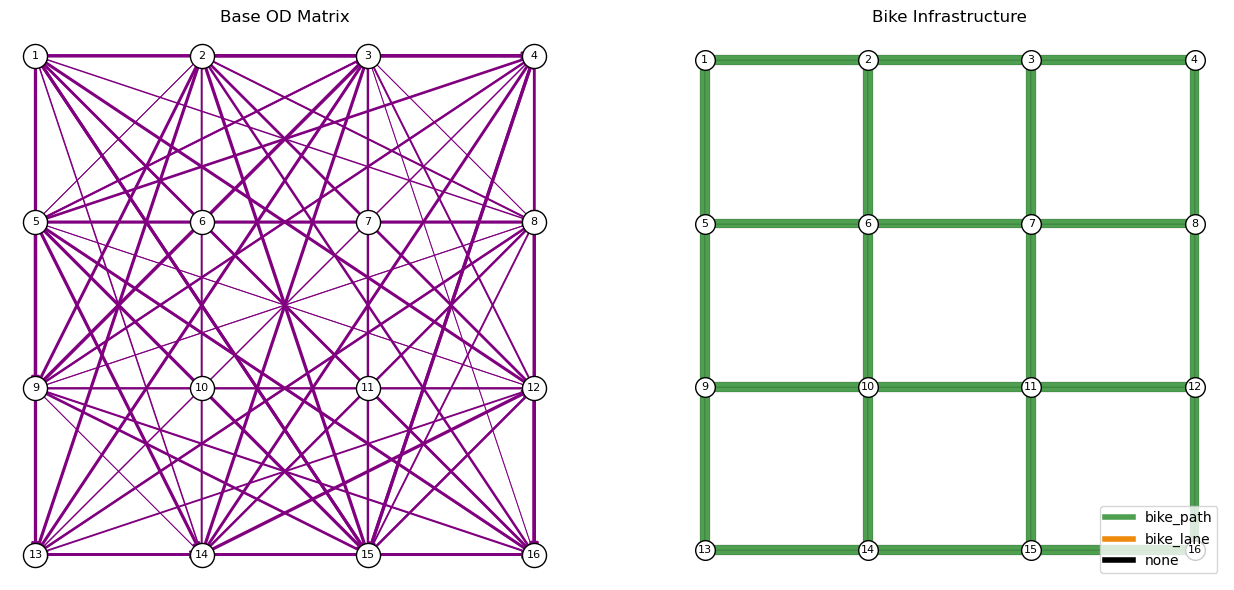


--- Iteration 1 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 4.171 %, Bike = 95.829%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 1 - Removing bike lane on edge Index([22], dtype='object') with flow 1447.7043640814793

--- Iteration 2 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 4.176 %, Bike = 95.824%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 2 - Removing bike lane on edge Index([18], dtype='object') with flow 1320.5528147067464

--- Iteration 3 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 4.276 %, Bike = 95.724%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 3 - Removing bike lane on edge Index([14], dtype='object') with flow 1195.3474846462564

--- Iteration 4 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 4.963 %, Bike = 95.037%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 4 - Removing bike lane on edge Index([7], dtype='object') with flow 1344.6405513429982

--- Iteration 5 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 4.966 %, Bike = 95.034%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 5 - Removing bike lane on edge Index([20], dtype='object') with flow 1036.0041325432426

--- Iteration 6 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 5.040 %, Bike = 94.960%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 6 - Removing bike lane on edge Index([34], dtype='object') with flow 1394.2656711102386

--- Iteration 7 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 5.547 %, Bike = 94.453%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 7 - Removing bike lane on edge Index([11], dtype='object') with flow 1516.2963443454585

--- Iteration 8 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 5.552 %, Bike = 94.448%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 8 - Removing bike lane on edge Index([13], dtype='object') with flow 1573.186955058495

--- Iteration 9 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 5.552 %, Bike = 94.448%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 9 - Removing bike lane on edge Index([27], dtype='object') with flow 926.9097567403879

--- Iteration 10 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 5.562 %, Bike = 94.438%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 10 - Removing bike lane on edge Index([15], dtype='object') with flow 761.5173103127715

--- Iteration 11 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 5.666 %, Bike = 94.334%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 11 - Removing bike lane on edge Index([40], dtype='object') with flow 1066.1823252047839

--- Iteration 12 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 5.737 %, Bike = 94.263%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 12 - Removing bike lane on edge Index([19], dtype='object') with flow 1284.5653671337725

--- Iteration 13 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 6.452 %, Bike = 93.548%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 13 - Removing bike lane on edge Index([32], dtype='object') with flow 1667.7808389090374

--- Iteration 14 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 6.453 %, Bike = 93.547%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 14 - Removing bike lane on edge Index([28], dtype='object') with flow 810.8275370045894

--- Iteration 15 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 6.480 %, Bike = 93.520%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 15 - Removing bike lane on edge Index([36], dtype='object') with flow 847.0044757081802

--- Iteration 16 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 6.697 %, Bike = 93.303%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 16 - Removing bike lane on edge Index([4], dtype='object') with flow 1747.5845482237694

--- Iteration 17 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 6.700 %, Bike = 93.300%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 17 - Removing bike lane on edge Index([16], dtype='object') with flow 647.6013334602801

--- Iteration 18 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 6.775 %, Bike = 93.225%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 18 - Removing bike lane on edge Index([30], dtype='object') with flow 1400.9756323721565

--- Iteration 19 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 7.330 %, Bike = 92.670%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 19 - Removing bike lane on edge Index([25], dtype='object') with flow 1843.290216462947

--- Iteration 20 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 7.334 %, Bike = 92.666%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 20 - Removing bike lane on edge Index([29], dtype='object') with flow 643.1290691512457

--- Iteration 21 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 7.423 %, Bike = 92.577%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 21 - Removing bike lane on edge Index([33], dtype='object') with flow 1516.9033772234588

--- Iteration 22 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 8.071 %, Bike = 91.929%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 22 - Removing bike lane on edge Index([43], dtype='object') with flow 2226.648340608553

--- Iteration 23 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 8.075 %, Bike = 91.925%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 23 - Removing bike lane on edge Index([17], dtype='object') with flow 1254.4603518211945

--- Iteration 24 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 8.170 %, Bike = 91.830%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 24 - Removing bike lane on edge Index([31], dtype='object') with flow 1299.2758725020508

--- Iteration 25 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 8.928 %, Bike = 91.072%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 25 - Removing bike lane on edge Index([9], dtype='object') with flow 3088.5043765247574

--- Iteration 26 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 9.820 %, Bike = 90.180%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 26 - Removing bike lane on edge Index([6], dtype='object') with flow 3041.3223844870677

--- Iteration 27 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 10.404 %, Bike = 89.596%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 27 - Removing bike lane on edge Index([38], dtype='object') with flow 3111.363853067598

--- Iteration 28 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 11.005 %, Bike = 88.995%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 28 - Removing bike lane on edge Index([41], dtype='object') with flow 2971.853453205289

--- Iteration 29 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 11.786 %, Bike = 88.214%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 29 - Removing bike lane on edge Index([0], dtype='object') with flow 3255.114749402939

--- Iteration 30 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 12.277 %, Bike = 87.723%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 30 - Removing bike lane on edge Index([10], dtype='object') with flow 3329.810519909862

--- Iteration 31 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 13.270 %, Bike = 86.730%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 31 - Removing bike lane on edge Index([24], dtype='object') with flow 3059.393806497664

--- Iteration 32 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 15.377 %, Bike = 84.623%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 32 - Removing bike lane on edge Index([44], dtype='object') with flow 3070.2537871156333

--- Iteration 33 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 17.066 %, Bike = 82.934%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 33 - Removing bike lane on edge Index([47], dtype='object') with flow 2805.306297475364

--- Iteration 34 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 18.975 %, Bike = 81.025%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 34 - Removing bike lane on edge Index([37], dtype='object') with flow 3182.1414593318855

--- Iteration 35 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 21.173 %, Bike = 78.827%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 35 - Removing bike lane on edge Index([23], dtype='object') with flow 2711.3030546372743

--- Iteration 36 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 26.103 %, Bike = 73.897%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 36 - Removing bike lane on edge Index([3], dtype='object') with flow 3117.78287010869

--- Iteration 37 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 31.672 %, Bike = 68.328%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 37 - Removing bike lane on edge Index([8], dtype='object') with flow 4100.425340655552

--- Iteration 38 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 34.982 %, Bike = 65.018%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 38 - Removing bike lane on edge Index([1], dtype='object') with flow 4161.098739662802

--- Iteration 39 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 39.915 %, Bike = 60.085%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 39 - Removing bike lane on edge Index([2], dtype='object') with flow 4562.423500061117

--- Iteration 40 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 46.906 %, Bike = 53.094%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 40 - Removing bike lane on edge Index([21], dtype='object') with flow 4470.966977935566

--- Iteration 41 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 56.075 %, Bike = 43.925%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 41 - Removing bike lane on edge Index([5], dtype='object') with flow 2910.9998922268987

--- Iteration 42 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 72.893 %, Bike = 27.107%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 42 - Removing bike lane on edge Index([35], dtype='object') with flow 2688.6119619297233

--- Iteration 43 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 76.904 %, Bike = 23.096%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 43 - Removing bike lane on edge Index([46], dtype='object') with flow 2577.016680077131

--- Iteration 44 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 81.499 %, Bike = 18.501%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 44 - Removing bike lane on edge Index([45], dtype='object') with flow 2719.818473845971

--- Iteration 45 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 86.153 %, Bike = 13.847%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 45 - Removing bike lane on edge Index([42], dtype='object') with flow 2539.1258945105765

--- Iteration 46 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 89.689 %, Bike = 10.311%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 46 - Removing bike lane on edge Index([39], dtype='object') with flow 2319.2315300008063

--- Iteration 47 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 95.130 %, Bike = 4.870%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 47 - Removing bike lane on edge Index([26], dtype='object') with flow 1257.9471613430212

--- Iteration 48 ---
➡️ Running mode choice...


Mode shares with skimming: Car = 98.757 %, Bike = 1.243%
➡️ Running traffic assignments...
➡️ Cars assignment...


✅ Cars assignment done.
➡️ Bikes assignment...
✅ Bikes assignment done.
✅ Traffic assignments completed.
Iteration 48 - Removing bike lane on edge Index([12], dtype='object') with flow 409.23830213282935


In [4]:
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")

edge_df_tri=edge_df.copy().reset_index(drop=True)
edge_df_tri['type_bike']= None

od_type = 'custom'  # 'custom' or 'random'

if od_type == 'random':
    od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
    od_matrix.loc[1,16] = 3000
    od_matrix.loc[13,4] = 3000
else :
    np.random.seed(69)
    od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
    liste_i = [1,2,3,4,5,9,13,15,14,16,12,8]
    for i in liste_i:
        for j in liste_i:
            if i != j:
                od_matrix.loc[i,j] = np.random.randint(30,500)


fig, axes = plt.subplots(1,2, figsize=(16,6))
plot_od_matrix(convert_to_eaquilibrae_od_matrix(od_matrix), edge_df_tri, node_df, label=False, title='Base OD Matrix', color='purple', vmax=1000, figsize=(6,6), ax=axes[0])

for edge in edge_df.itertuples():
    edge_df_tri = change_type_bike(edge_df_tri, edge.a_node, edge.b_node, 'bike_path')
plot_network(edge_df_tri, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,title='Bike Infrastructure', figsize=(6,6), edges_label_col='index', ax=axes[1])
plt.show()

# counter
i = 0
limit = 100

# parameters for stochastic assignment
beta = 1
cutoff_prob = 0.0

# parameters for mode choice
beta_time = -0.01
ASC_car = 0
ASC_bike = -2.5

impact_coef = 1
mu_mode = 1.0
loop_count = 4

plot = False
# other parameters
speed_bike = 17
speed_car = 20
speed_bike = speed_bike / 3.6 # in m/s
speed_car = speed_car / 3.6 # in m/s

edge_df_tri["flow_car"] = 0
edge_df_tri["flow_bike"] = 0
edge_df_tri["speed_car"] = speed_car
edge_df_tri["speed_bike"] = speed_bike
edge_df_tri["capacity_cars"]= 4000
edge_df_tri["capacity_bikes"]= 9999
edge_df_tri["alpha"]=0.15
edge_df_tri["beta"]=4.0

edge_df_tri = free_flow_time(edge_df_tri, 'car')
edge_df_tri = free_flow_time(edge_df_tri, 'bike')
edge_df_tri["length_bi"] = edge_df_tri["length"]

edge_df_tri["travel_time_car"] = edge_df_tri['free_flow_time_car']
edge_df_tri["travel_time_bike"] = edge_df_tri['free_flow_time_bike']
nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()

results_df_mc = pd.DataFrame({'iteration_loop': [0],
                              'iteration_mode_choice': [0],
                            'modal_share_car': [np.nan],
                            'modal_share_bike': [np.nan],
                            'total_travel_time_car': [np.nan],
                            'total_travel_time_bike': [np.nan],
                            'travel_time_per_car': [np.nan],
                            'travel_time_per_bike': [np.nan]})

results_df = pd.DataFrame({'iteration': [0],
                        'nbr_bike_lanes': nbr_bike_lanes,
                        'nbr_none_bike_lanes': nbr_none_bike_lanes,
                        'modal_share_car': [np.nan],
                        'modal_share_bike': [np.nan]})

while nbr_bike_lanes > 0 and i < limit :
    i += 1
    print(f"\n--- Iteration {i} ---")
    

    # mode choice adjustment
    j = 0
    print("➡️ Running mode choice...")
    while j < loop_count:
        if plot:
            print(f"\n--- Mode Choice Loop {j+1} ---")
        j += 1
        

        #create skim matrices
        skim_car = np.zeros((16,16))
        skim_bike = np.zeros((16,16))

        # Car skimming using current edge travel times
        G_car = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_car.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_car'])

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_car[origin-1, destination-1] = nx.shortest_path_length(G_car, source=origin, target=destination, weight='time')
                    except:
                        skim_car[origin-1, destination-1] = 9999

        # Bike skimming using current edge travel times with length_bi
        
        G_bike = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_bike.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_bike'])

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_bike[origin-1, destination-1] = nx.shortest_path_length(G_bike, source=origin, target=destination, weight='time')
                    except:
                        skim_bike[origin-1, destination-1] = 9999

        # Calculate utilities and mode share for each OD pair
        od_mode_shares_skim = np.zeros((16,16,2)) # 3rd dimension: 0 for car, 1 for bike
        total_car_skim = 0
        total_bike_skim = 0

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination and od_matrix.loc[origin, destination] > 0:
                    # Utilities
                    V_car = ASC_car + beta_time * skim_car[origin-1, destination-1]
                    V_bike = ASC_bike + beta_time * skim_bike[origin-1, destination-1] # TO MODIFY FOR AN OTHER UTILITY FUNCTION

                    # Probabilities using logit model
                    exp_car = np.exp(mu_mode * V_car)
                    exp_bike = np.exp(mu_mode * V_bike)
                    P_car = exp_car / (exp_car + exp_bike)
                    P_bike = exp_bike / (exp_car + exp_bike)

                    od_mode_shares_skim[origin-1, destination-1, 0] = P_car
                    od_mode_shares_skim[origin-1, destination-1, 1] = P_bike

                    # Accumulate total mode shares
                    total_car_skim += od_matrix.loc[origin, destination] * P_car
                    total_bike_skim += od_matrix.loc[origin, destination] * P_bike
        if plot:            
            print(f"Mode shares with skimming: Car = {total_car_skim/(total_car_skim+total_bike_skim)*100 :.3f} %, Bike = {total_bike_skim/(total_car_skim+total_bike_skim)*100:.3f}%")
        # Update OD matrices based on mode shares
        updated_od_car = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
        updated_od_bike = pd.DataFrame(0, index=range(1,17), columns=range(1,17))

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    total_od = od_matrix.loc[origin, destination]
                    P_car = od_mode_shares_skim[origin-1, destination-1, 0]
                    P_bike = od_mode_shares_skim[origin-1, destination-1, 1]
                    updated_od_car.loc[origin, destination] = total_od * P_car
                    updated_od_bike.loc[origin, destination] = total_od * P_bike
        
        updated_od_car = convert_to_eaquilibrae_od_matrix(updated_od_car)
        updated_od_bike = convert_to_eaquilibrae_od_matrix(updated_od_bike)

        #run traffic assignments with updated OD matrices
        car_results_mode_choice = ta_due(
                                    edge_df_tri,
                                    updated_od_car,
                                    algorithm='bfw',
                                    time_field='travel_time_car',
                                    cost_field='length',
                                    max_iter=500,
                                    tolerance=1e-4,
                                    capacity_field='capacity_cars'
                                    )
        
        edge_df_tri = car_results_mode_choice['network'].copy()
        edge_df_tri["flow_car"] = edge_df_tri["flow"]
        edge_df_tri["ratio_flow_capacity_car"] = edge_df_tri["ratio"]
        edge_df_tri = pd.DataFrame.from_dict(edge_df_tri)
        if plot :
            plot_vc_histogram(edge_df_tri, capacity_col='capacity_cars', bins=20)

        edge_df_tri = simple_bi_3(edge_df_tri, traffic_car_col='flow_car', coef=impact_coef)
        edge_df_tri['travel_time_bike'] = edge_df_tri['length_bi']/speed_bike

        bike_results_mode_choice = ta_stochastic(
                                    edge_df_tri, 
                                    updated_od_bike, 
                                    mode='bikes',
                                    time_field='travel_time_bike', 
                                    cost_field='length_bi', ### LENGTH OR LENGTH_BI?
                                    algorithm='bfsle', 
                                    max_routes=3,
                                    capacity_field='capacity_bikes',
                                    beta=beta,
                                    cutoff_prob=cutoff_prob
                                    )
        
        edge_df_tri = bike_results_mode_choice['network'].copy()
        edge_df_tri["flow_bike"]= edge_df_tri["flow"]
        edge_df_tri = pd.DataFrame.from_dict(edge_df_tri)

        #calculate congested time for cars
        calculate_congested_time(edge_df_tri, flow_name='flow_car',free_flow_time_name='free_flow_time_car', capacity_name="capacity_cars", congested_time_name='travel_time_car', alpha=0.15, beta=4)
        if plot:
            fig, axes = plt.subplots(2,2, figsize=(10,10))
            plot_network(edge_df_tri, node_df, width_col='flow_car', color_col_num='flow_car', cmap='Reds', title=f'Car flows- Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (cars)', base_width=1, width_scale=50, ax=axes[0,0])
            plot_network(edge_df_tri, node_df, width_col='flow_bike', color_col_num='flow_bike', cmap='Greens', title=f'Bike flows - Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (bikes)', base_width=1, width_scale=50, ax=axes[0,1])
            plot_network(edge_df_tri, node_df, color_col_num='travel_time_car', cmap='hot_r', title=f'Car Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,0])
            plot_network(edge_df_tri, node_df, color_col_num='travel_time_bike', cmap='hot_r', title=f'Bike Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,1])
            plt.show()
            plot_network(edge_df_tri, node_df, color_col_num='length_bi', base_width=1, legend=True,  node_label=True,title=f'length_bi - Loop {j}', figsize=(5,5), edges_label_col='index', cmap='viridis_r')
            plt.show()
        
        total_travel_time_car = (edge_df_tri['travel_time_car'] * edge_df_tri['flow_car']).sum()
        total_travel_time_bike = (edge_df_tri['travel_time_bike'] * edge_df_tri['flow_bike']).sum()

        results_df_mc = pd.concat([results_df_mc, pd.DataFrame({'iteration_loop': [i],
                                              'iteration_mode_choice': j,
                                              'modal_share_car': 100*total_car_skim / od_matrix.values.sum(),
                                              'modal_share_bike': 100*total_bike_skim / od_matrix.values.sum(),
                                              'total_travel_time_car': total_travel_time_car,
                                              'total_travel_time_bike': total_travel_time_bike,
                                              'travel_time_per_car': total_travel_time_car / updated_od_car.values.sum(),
                                              'travel_time_per_bike': total_travel_time_bike / updated_od_bike.values.sum()})], ignore_index=True)

    print(f"Mode shares with skimming: Car = {total_car_skim/(total_car_skim+total_bike_skim)*100 :.3f} %, Bike = {total_bike_skim/(total_car_skim+total_bike_skim)*100:.3f}%")
    od_bike = updated_od_bike.copy()
    od_car = updated_od_car.copy()

    print("➡️ Running traffic assignments...")
    print("➡️ Cars assignment...")

    name_col_flow_car = 'flow_car_iteration_'+str(i)
    name_col_flow_bike = 'flow_bike_iteration_'+str(i)

    # run car traffic assignment
    cars_results = ta_due(edge_df_tri,
                          od_car,
                          algorithm='bfw',
                          time_field='travel_time_car',
                          cost_field='length',
                          max_iter=500,
                          tolerance=1e-4,
                          capacity_field='capacity_cars'
                          )
    edge_df_tri = cars_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

    print("✅ Cars assignment done.")
    print("➡️ Bikes assignment...")

    #recalculate bike infrastructure
    edge_df_tri = simple_bi_3(edge_df_tri, traffic_car_col=name_col_flow_car, coef=impact_coef)

    #run bike traffic assignment
    bike_results = ta_stochastic(
                                edge_df_tri, 
                                od_bike, 
                                mode='bikes',
                                time_field='free_flow_time_bike', 
                                cost_field='length_bi',
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                beta=beta,
                                cutoff_prob=cutoff_prob
                                )
    
    edge_df_tri = bike_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

    print("✅ Bikes assignment done.")
    print("✅ Traffic assignments completed.")

    #identify edges considered for removal
    edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
    indexes_removed = pd.Index([])
    #select index of least used edge
    index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index[0]
    indexes_removed = indexes_removed.union(pd.Index([index_least_used]))
    #remove infrastructures from selected edges
    edge_df_tri.loc[indexes_removed, 'type_bike'] = None

    print(f"Iteration {i} - Removing bike lane on edge {indexes_removed} with flow {edge_df_tri.loc[index_least_used, name_col_flow_bike]}")
   
    nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
    nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
    flow_of_removed_edge = edge_df_tri.loc[index_least_used, name_col_flow_bike]
    results_df = pd.concat([results_df, 
                            pd.DataFrame({'iteration': [i+1],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [indexes_removed],'flow_of_removed_edge': [flow_of_removed_edge]})
                            ], ignore_index=True)

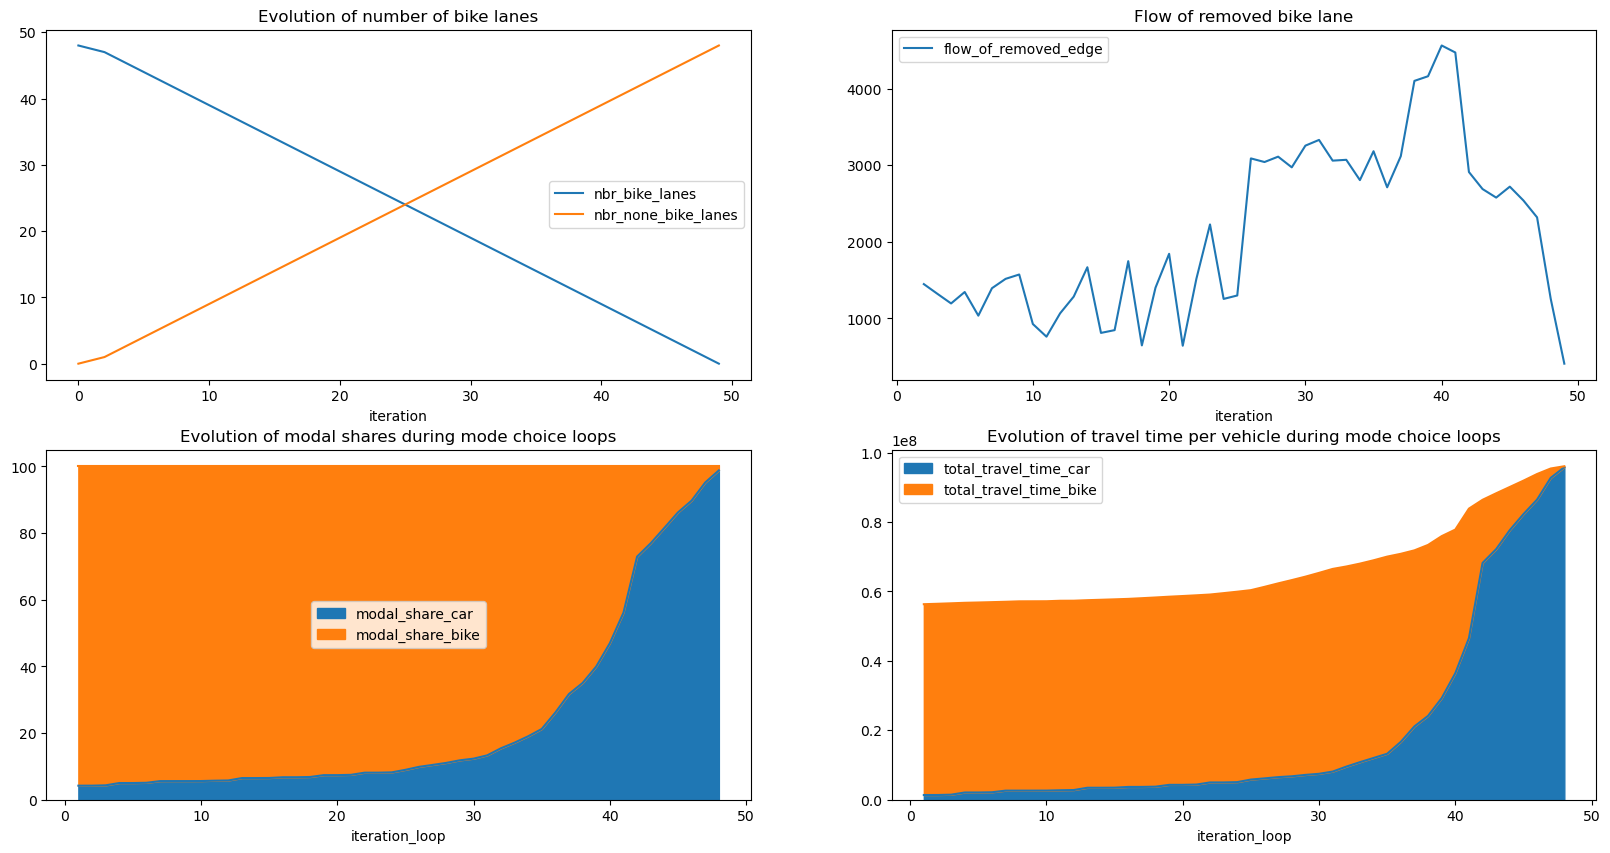

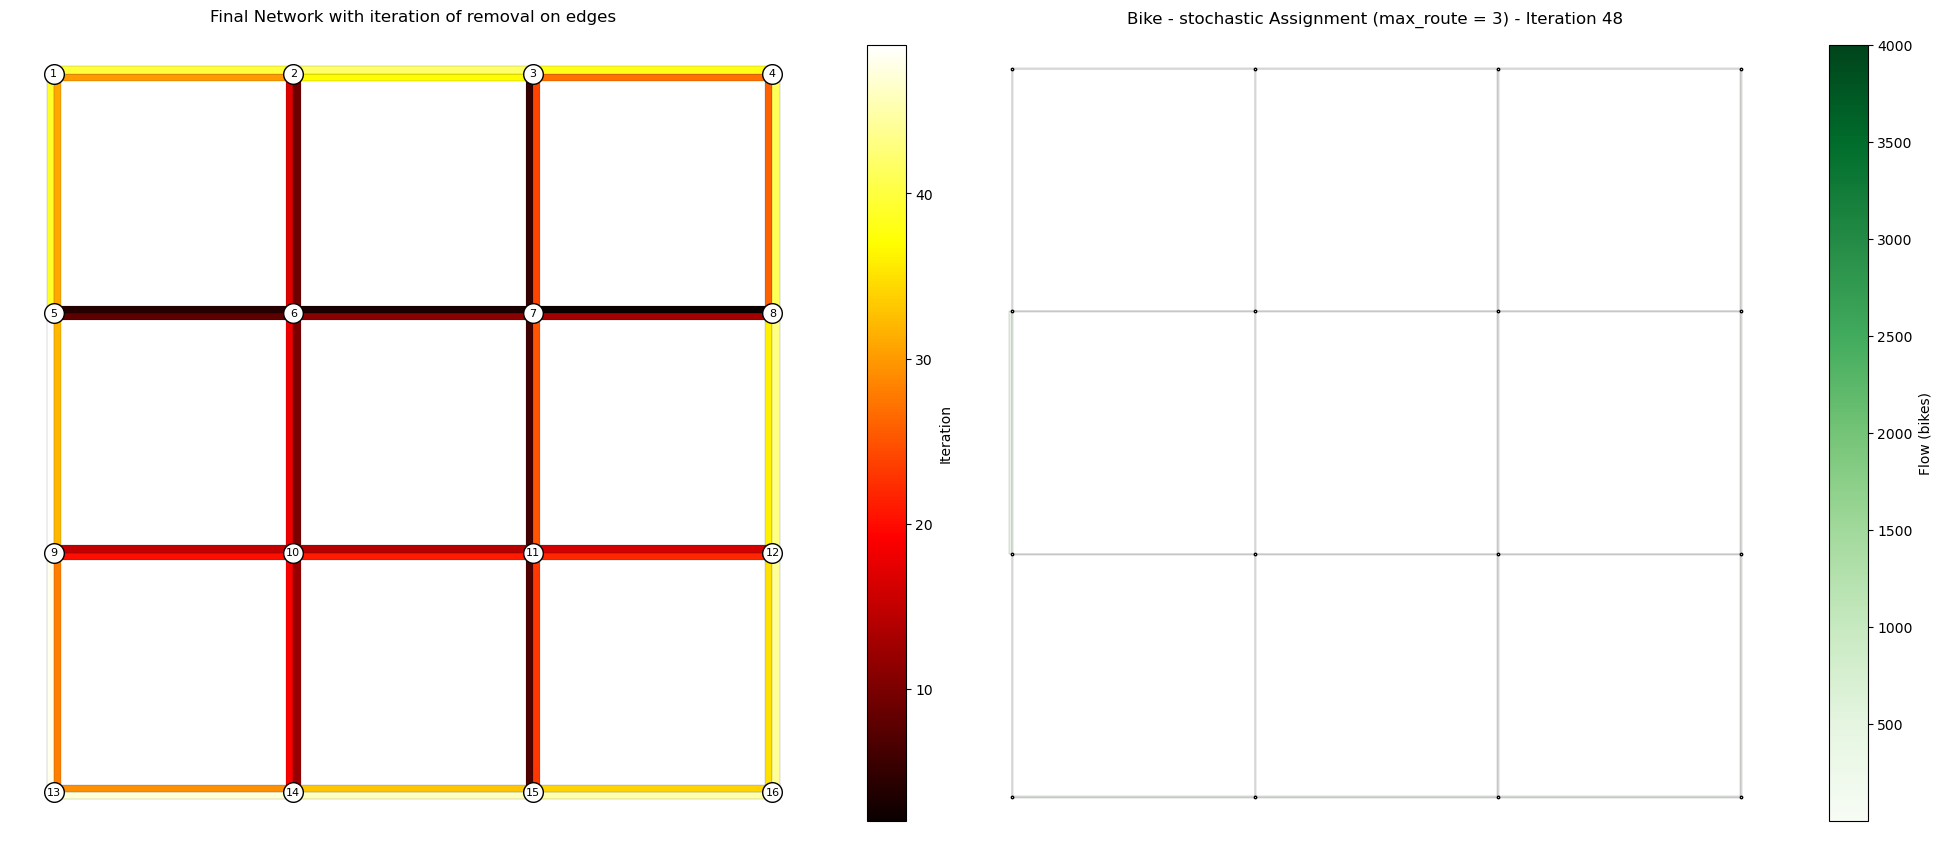

Proposed network with budget 10 has a flow coverage of 75.79%.


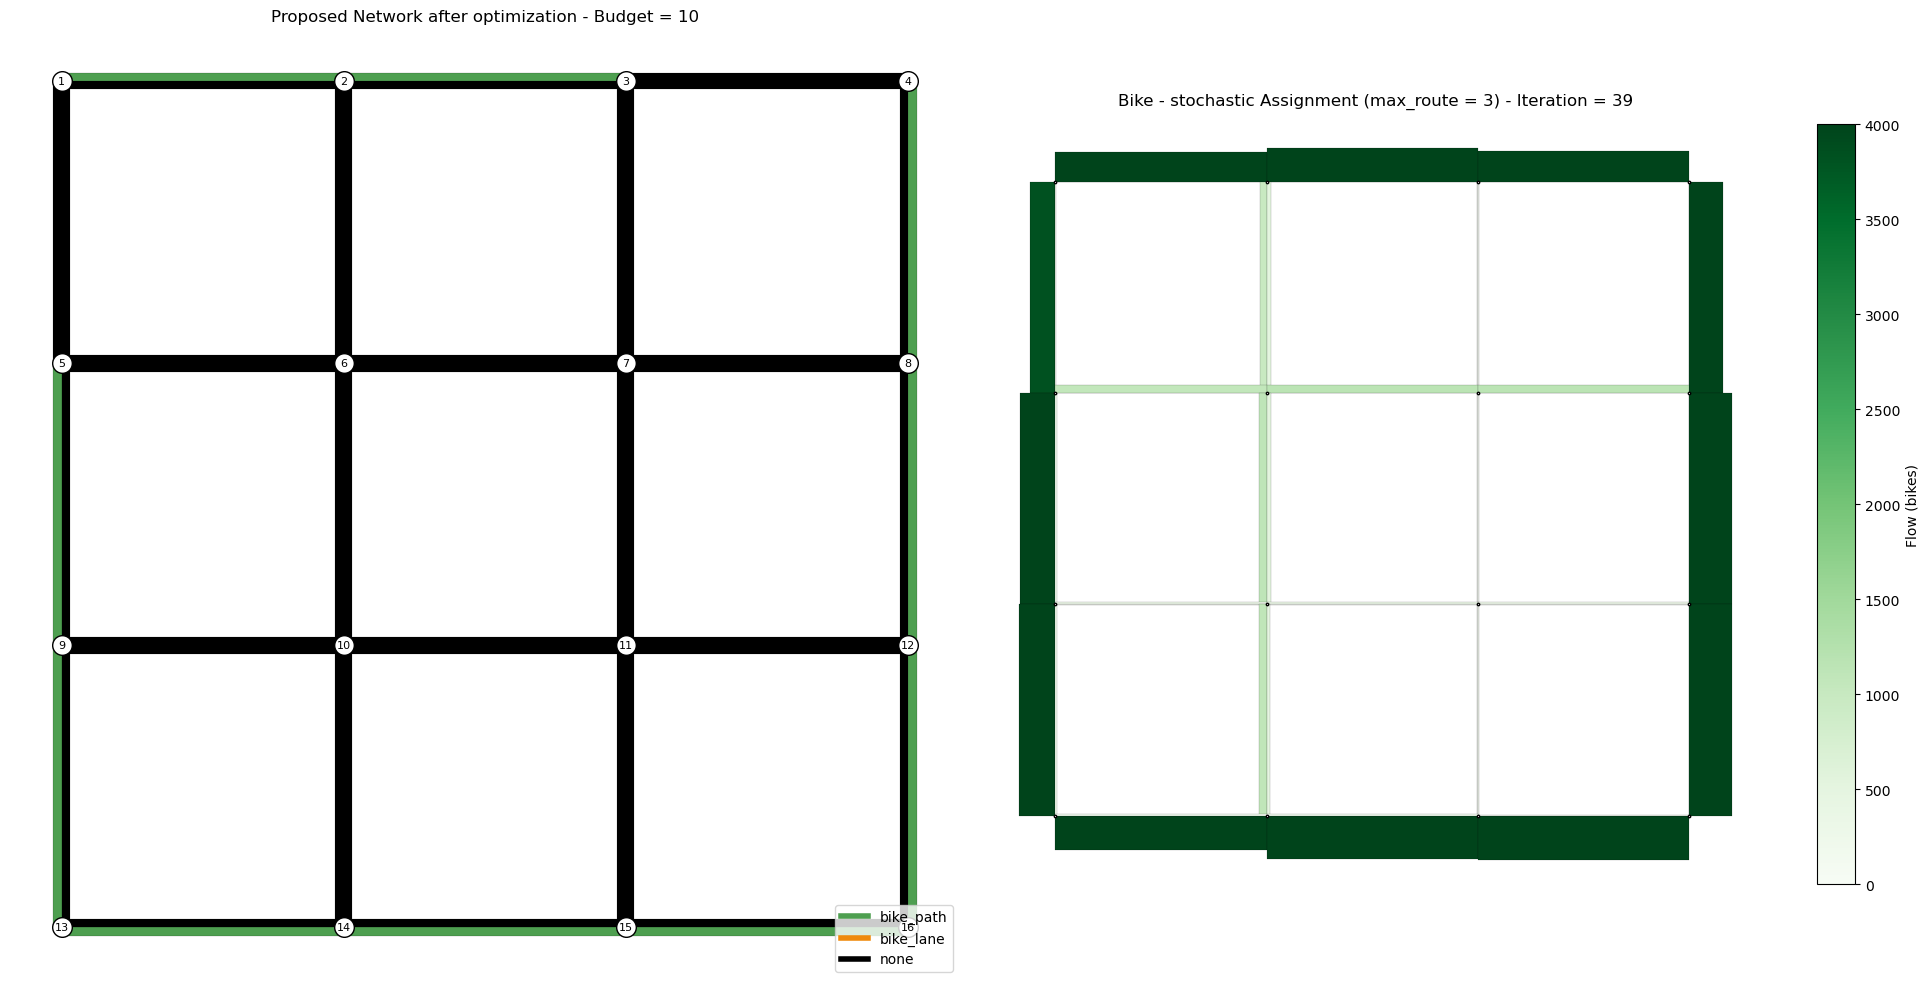

In [5]:
edge_df_final = edge_df_tri.copy()
results_df_exploded = results_df.explode('index_removed', ignore_index=True)
edge_df_final = pd.merge(edge_df_final, results_df_exploded[['iteration','index_removed']], left_index=True, right_on='index_removed', how='left')
results_df_mc_final = results_df_mc[results_df_mc['iteration_mode_choice']==4]
results_df_mc_final['total_travel_time'] = results_df_mc_final['total_travel_time_car'] + results_df_mc_final['total_travel_time_bike']
fig, axes = plt.subplots(2,2, figsize=(20,10))
results_df.plot.line(x='iteration', y=['nbr_bike_lanes','nbr_none_bike_lanes'], title='Evolution of number of bike lanes', ax=axes[0,0])
results_df.plot.line(x='iteration', y='flow_of_removed_edge', title='Flow of removed bike lane', ax=axes[0,1])
results_df_mc_final.plot.area(x='iteration_loop', y=['modal_share_car','modal_share_bike'], title='Evolution of modal shares during mode choice loops', ax=axes[1,0])
results_df_mc_final.plot.area(x='iteration_loop', y=['total_travel_time_car','total_travel_time_bike'], title='Evolution of travel time per vehicle during mode choice loops', ax=axes[1,1])
plt.show()
fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_final, node_df, color_col_num='iteration', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,  title='Final Network with iteration of removal on edges', ax=axes[0], cmap='hot')
plot_network(
        bike_results['network'], node_df,
        width_col='flow',
        color_col_num='flow',
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration {i}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
plt.show()  
edge_df_proposed = edge_df_final.copy()


budget = 10
iteration = len(edge_df_proposed) - budget + 1
edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
flow_coverage = edge_df_proposed[edge_df_proposed['type_bike'] == 'bike_path']['flow_bike_iteration_'+str(iteration)].sum()/edge_df_proposed['flow_bike_iteration_'+str(iteration)].sum()

fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_proposed, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, title='Proposed Network after optimization - Budget = '+str(budget), figsize=(10,10), edges_label_col='index', ax=axes[0])
plot_network(
        edge_df_proposed, node_df,
        width_col='flow_bike_iteration_'+str(iteration),
        color_col_num='flow_bike_iteration_'+str(iteration),
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration = {iteration}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
print(f"Proposed network with budget {budget} has a flow coverage of {flow_coverage*100:.2f}%.")


In [48]:
from matplotlib.animation import FuncAnimation

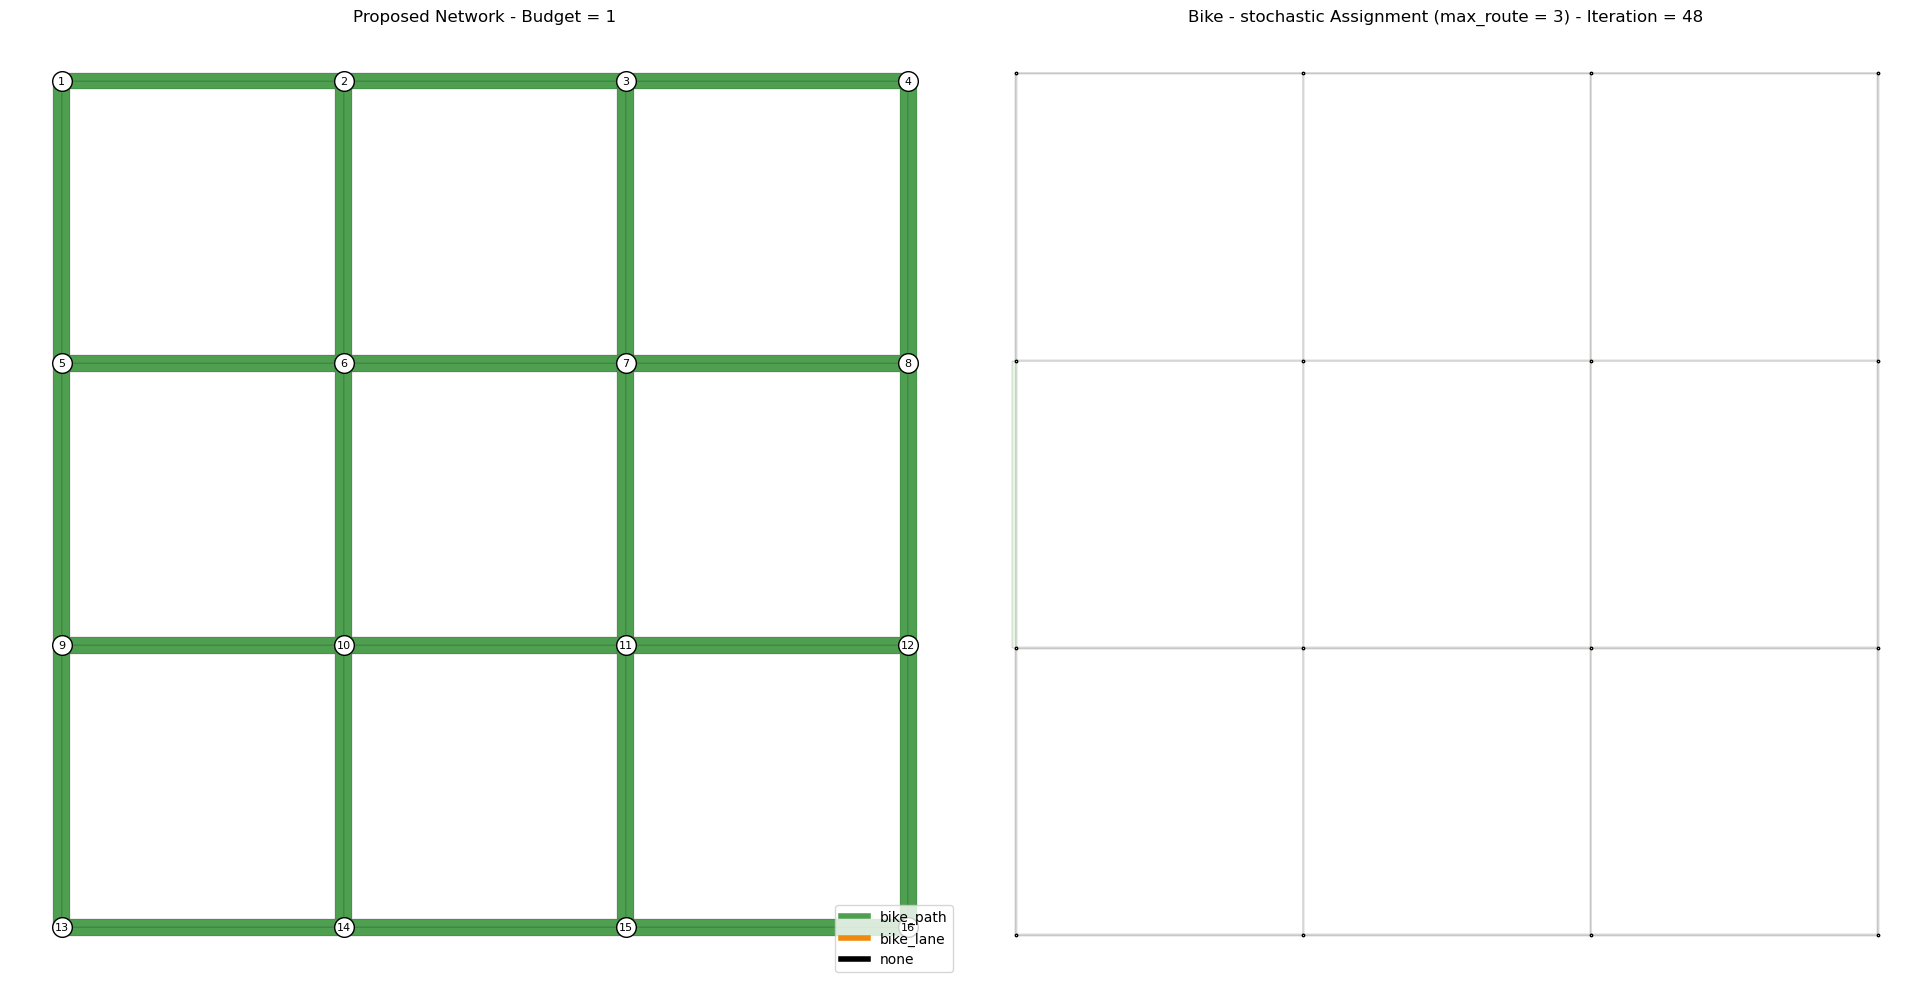

In [18]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
edge_df_proposed = edge_df_final.copy()
cbar_exists = False
# 1. Configuration initiale
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

def update(budget):
    global cbar_exists
    # On vide les axes pour redessiner proprement
    axes[0].clear()
    axes[1].clear()
    
    # Calcul de l'itération dynamique selon votre formule
    iteration = len(edge_df_proposed) - budget + 1
    
    # Premier graphique (Réseau proposé)
    plot_network(
        edge_df_proposed, node_df, 
        color_col_str='type_bike', base_width=1, width_scale=5, 
        node_size=200, legend=True, node_label=True, 
        title=f'Proposed Network - Budget = {budget}', 
        ax=axes[0]
    )

    # Second graphique (Assignation stochastique)
    # On utilise l'itération calculée au-dessus pour les noms de colonnes
    flow_col = f'flow_bike_iteration_{iteration}'
    edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
    plot_network(
        edge_df_proposed, node_df,
        width_col='flow_bike_iteration_'+str(iteration),
        color_col_num='flow_bike_iteration_'+str(iteration),
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration = {iteration}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000,
        cbar_on=False
    )
    if cbar_exists:
            # On cherche la dernière colorbar ajoutée à la figure et on la retire
            # Les colorbars sont stockées dans fig.axes
            if len(fig.axes) > 3: # 2 axes originaux + 1 legende + la nouvelle cbar
                fig.axes[-1].remove()
    else:
        cbar_exists = True

# 2. Animation (de budget 0 à 48 inclus)
ani = FuncAnimation(fig, update, frames=range(1, 49), interval=400)

ani.save("animation.gif", writer='pillow')